# BIOHEAT TRANSFER IN A BIOLOGICAL TISSUE(assumed single layer)
# using PENNES BIOHEAT EQUATION

In [5]:
import matplotlib.pyplot as plt



In [6]:
pip install pyDOE

Note: you may need to restart the kernel to use updated packages.


# All constants
Assumption : tissue as a single layer(l1) of same depth

In [7]:
#constant temp at the top of the tissue
u_c = 12 # deg Celcius (above the normal temp of the tissue) 

#laser power
P = 6.4
# time for the simulation

sim_time = 150 # seconds

#shape of the tissue

length = 10 # mm
width = 10  # mm
depth = 12.08 # mm

sigma = 1 # Standard devaition of Laser beam width (mm)

#for layer l1 : Epidermis layer

l1 = 0.08 # thickness of the layer(mm)
rho1 = 0.0012 # density thickness of the layer (g/mm^3)
C1 = 3.6 # specific heat (J/g. deg Celsius)
Cb1 = 4.2 # specific heat of the blood (J/g. deg Celsius)
K1 = 0.00026 # thermal conductivity of the tissue (W/mm. deg Celsius)
Wb1 = 0 # Blood perfusion rate (g/mm^3. s)
alpha1 = 0.1 #laser absorbtivity of the first layer
Reff1 = 0.93 # Laser reflectivity of the first layer 
Q1 = lambda x,y,z : (1/(2*torch.pi*sigma**2))*alpha1*torch.exp(-alpha1*z)*torch.exp(-1*(x**2+y**2)/(2*sigma**2))*P*(1-Reff1) #Volumetric heat due to spatial heating

#for layer l2 : Dermis layer

l2 = 2 # thickness of the layer(mm)
rho2 = 0.0012 # density thickness of the layer (g/mm^3)
C2 = 3.4 # specific heat (J/g. deg Celsius)
Cb2 = 4.2 # specific heat of the blood (J/g. deg Celsius)
K2 = 0.00052 # thermal conductivity of the tissue (W/mm. deg Celsius)
Wb2 = 5 * 10**(-7) # Blood perfusion rate (g/mm^3. s)
alpha2 = 0.08 #laser absorbtivity of the first layer
Reff2 = 0.93 # Laser reflectivity of the first layer 
Q2 = lambda x,y,z : (1/(2*torch.pi*sigma**2))*alpha2*torch.exp(-alpha1*rho1)*torch.exp(-alpha2*z)*torch.exp(-1*(x**2+y**2)/(2*sigma**2))*P*(1-Reff2) #Volumetric heat due to spatial heating

#for layer l3 : Subcutaneous layer

l3 = 10 # thickness of the layer(mm)
rho3 = 0.001 # density thickness of the layer (g/mm^3)
C3 = 3.06 # specific heat (J/g. deg Celsius)
Cb3 = 4.2 # specific heat of the blood (J/g. deg Celsius)
K3 = 0.00021 # thermal conductivity of the tissue (W/mm. deg Celsius)
Wb3 = 5 * 10**(-7) # Blood perfusion rate (g/mm^3. s)
alpha3 = 0.04 #laser absorbtivity of the first layer
Reff3 = 0.93 # Laser reflectivity of the first layer 
Q3 = lambda x,y,z : (1/(2*torch.pi*sigma**2))*alpha3*torch.exp(-alpha1*rho1)*torch.exp(-alpha2*rho2)*torch.exp(-alpha3*z)*torch.exp(-1*(x**2+y**2)/(2*sigma**2))*P*(1-Reff3) #Volumetric heat due to spatial heating

In [8]:
import time
import torch
import numpy as np
import scipy.io
from pyDOE import lhs
from physicsinformed import PhysicsInformedContinuous
from scipy.interpolate import griddata
import utilities

# Select gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float

# Set seed for the Random Number Generator (RNG), setting the seed generates same set of random numbers everytime 
torch.manual_seed(450)
np.random.seed(450) 

# Define no. of training points
N0 = 400 # intial values at t = 0 (0,x,z)
N_b = 500
N_f = 20000

# Define feed-forward network architecture
layers = [3, 20, 20, 20, 20, 1]

# Define no. of epochs for each optimizer
epochs_Adam = 8000
epochs_LBFGS = 1000

# Domain bounds
lb = np.array([0,0,0])  # minimum(t,x,z)
ub = np.array([sim_time,length,depth]) # maximum(t,x,z)

lic  = [l1,(l1+l2),(l1+l2+l3)] #layer_interface_coordinates


# Create collocation points with latin hypercube sampling
txz_f = lb + (ub - lb) * lhs(3, N_f) # Creates 20000 sample points in x, y, z and t


# Transform grid into vectors that can be processed by the neural net
'''X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None])) #Stack arrays in sequence horizontally (column wise)
u_star = u_sol.flatten()[:, None]
flux_star = flux_sol.flatten()[:, None]
'''

# Select random data points for the initial condition
id_rand = np.random.choice(txz_f.shape[0], N0, replace=False) # Choose random 100 indices from 256 total indices of space
x0 = txz_f[:,1:2][id_rand, :] # location of these 100 random points
id_rand1 = np.random.choice(txz_f.shape[0], N0, replace=False)
z0 = txz_f[:,2:3][id_rand1, :]
xz0 = np.concatenate((0 * x0, x0, z0), 1) # (0,x0,z0) initial condition

# Select random data points for the boundary condition

# for z= 0 => (t,x,0)
id_tb = np.random.choice(txz_f.shape[0], N_b, replace=False) # Choose random 50 indices from 201 total indices of time
tb = txz_f[:,0:1][id_tb, :] # time stamps of those 50 indices
id_xb = np.random.choice(txz_f.shape[0], N_b, replace=False)
xb = txz_f[:,1:2][id_xb, :]

tx0b = np.concatenate((tb, xb, 0*tb), 1)  # for calculating error for this cond>>add error term 3times for
                                               # 3 layers with different parameters

    
# for the lateral surfaces (boundary conditions)

# x-z plane -> ((t,x,y_lb,z) & (t,x,y_ub,z))
#coordinates for lateral surfaces

id_t_surface1 = np.random.choice(txz_f.shape[0], N_b, replace=False)
t_xz_ = txz_f[:,0:1][id_t_surface1, :]
id_x_surface2 = np.random.choice(txz_f.shape[0], N_b, replace=False) 
x_xz_ = txz_f[:,1:2][id_x_surface2, :]
id_z_surface3 = np.random.choice(txz_f.shape[0], N_b, replace=False)
z_xz_ = txz_f[:,2:3][id_z_surface3, :]

xz_lb = np.concatenate((t_xz_, x_xz_ , z_xz_ ), 1) # (t,x,z)  


## input data for the bottom (@ z = depth)

id_t_int = np.random.choice(txz_f.shape[0], N_b, replace=False) # Choose random N_b indices from 20000 total indices 
t_int_ = txz_f[:,0:1][id_t_int, :] # time stamps of those N_b indices
id_x_int = np.random.choice(txz_f.shape[0], N_b, replace=False)
x_int_ = txz_f[:,1:2][id_x_int, :]

txz_int_l3 = np.concatenate((t_int_, x_int_, 0 * t_int_ + lic[2] ), 1)


### TRAINING ###
# Create torch.tensors of training data

#for the initial condition at t=0 # we will have to consider all 3 layers if assumption is removed

t_0 = torch.tensor(xz0[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_0 = torch.tensor(xz0[:, 1:2], dtype=dtype, requires_grad=True, device=device)
z_0 = torch.tensor(xz0[:, 2:3], dtype=dtype, requires_grad=True, device=device)

#for the surface boundary condition -> z=0

t_b = torch.tensor(tx0b[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_b = torch.tensor(tx0b[:, 1:2], dtype=dtype, requires_grad=True, device=device)
z_b = torch.tensor(tx0b[:, 2:3], dtype=dtype, requires_grad=True, device=device)


#for the lateral boundary condition -> lateral surafces x-z and y-z planes # we need to consider all 3 layers if assumption is removed

t_xz_lb = torch.tensor(xz_lb[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_xz_lb = torch.tensor(xz_lb[:, 1:2], dtype=dtype, requires_grad=True, device=device)
z_xz_lb = torch.tensor(xz_lb[:, 2:3], dtype=dtype, requires_grad=True, device=device)

# for the interfaces between the layers (@ l1 ,@ l1+l2 ,@ l1+l2+l3) but for our assumption we take single layer

t_int = torch.tensor(t_int_, dtype=dtype, requires_grad=True, device=device)
x_int = torch.tensor(x_int_, dtype=dtype, requires_grad=True, device=device)

#for layer 3 (if we consider only single layer, this z will be used for training)

z_int_l3 = torch.tensor(0 * t_int_ + lic[2] , dtype=dtype, requires_grad=True, device=device)

# for the functional error
t_f = torch.tensor(txz_f[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_f = torch.tensor(txz_f[:, 1:2], dtype=dtype, requires_grad=True, device=device)
z_f = torch.tensor(txz_f[:, 2:3], dtype=dtype, requires_grad=True, device=device)

# Initialize PINN model
PINNModel = PhysicsInformedContinuous(layers, t_0,x_0,z_0, t_b, x_b, z_b, t_xz_lb,x_xz_lb,z_xz_lb, t_int, x_int, z_int_l3, t_f, x_f, z_f,u_c, Q1)

# Train the model
start_time = time.time()
PINNModel.train(10000, optimizer='Adam', lr=0.002)
#PINNModel.train(epochs_LBFGS, optimizer='L-BFGS')
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))


# Plot training history and predicitons
PINNModel.plot_training_history()

Sequential(
  (0): Linear(in_features=3, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): Tanh()
  (8): Linear(in_features=20, out_features=1, bias=True)
)
model parameters on gpu: False
Epoch (Adam): 0, Cost: 1429.9390869140625, Bound_loss: 1429.9305419921875, Fun_loss: 0.00017090207256842405, Ini_loss: 0.008454868569970131
Epoch (Adam): 100, Cost: 392.545166015625, Bound_loss: 384.3748474121094, Fun_loss: 6.781871318817139, Ini_loss: 1.3884532451629639
Epoch (Adam): 200, Cost: 96.34196472167969, Bound_loss: 90.8175277709961, Fun_loss: 4.6391921043396, Ini_loss: 0.8852436542510986
Epoch (Adam): 300, Cost: 21.144094467163086, Bound_loss: 16.685054779052734, Fun_loss: 3.694406032562256, Ini_loss: 0.7646324634552002
Epoch (Adam): 400, Cost: 7.252781867980957, Bound_loss: 3.2906291484832764

Epoch (Adam): 5600, Cost: 0.0321880541741848, Bound_loss: 0.009694804437458515, Fun_loss: 0.02055623009800911, Ini_loss: 0.001937020686455071
Epoch (Adam): 5700, Cost: 0.02933233417570591, Bound_loss: 0.008411695249378681, Fun_loss: 0.01986592449247837, Ini_loss: 0.0010547139681875706
Epoch (Adam): 5800, Cost: 0.0286960881203413, Bound_loss: 0.008343519642949104, Fun_loss: 0.019328700378537178, Ini_loss: 0.001023868564516306
Epoch (Adam): 5900, Cost: 0.02812008000910282, Bound_loss: 0.008266598917543888, Fun_loss: 0.01883595995604992, Ini_loss: 0.0010175209026783705
Epoch (Adam): 6000, Cost: 0.027430817484855652, Bound_loss: 0.008174908347427845, Fun_loss: 0.018320471048355103, Ini_loss: 0.0009354370413348079
Epoch (Adam): 6100, Cost: 0.026964012533426285, Bound_loss: 0.00818469375371933, Fun_loss: 0.017839927226305008, Ini_loss: 0.0009393916116096079
Epoch (Adam): 6200, Cost: 0.02941322885453701, Bound_loss: 0.00957015436142683, Fun_loss: 0.017598753795027733, Ini_loss: 0.002244320930

KeyboardInterrupt: 

# Results of the PINN model
The below plot shows the Temperatures at different depths of the tissue after heating the tissue for 150s with a constant heat source at the surface of the tissue

Text(0.5, 1.0, 'PINN Solution')

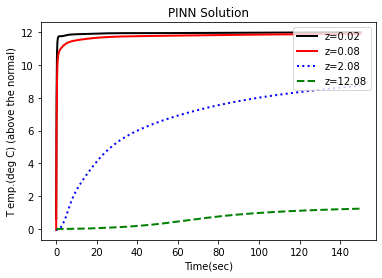

In [70]:
n = 1500
l = 1500
f=[0.02,0.08,2.08,12.08]
x_star = torch.tensor(np.array([np.linspace(0,length,n)]).T, dtype=dtype, requires_grad=True, device=device)
z_star = torch.tensor(np.array([np.linspace(0,depth,n)]).T, dtype=dtype, requires_grad=True, device=device)
t_star = torch.tensor(np.array([np.linspace(0,sim_time,n)]).T, dtype=dtype, requires_grad=True, device=device)

T1 = PINNModel.u_nn(t_star, x_star*0,z_star*0+f[0]).detach().cpu().numpy().T[0][0:l]
T2 = PINNModel.u_nn(t_star, x_star*0,z_star*0+f[1]).detach().cpu().numpy().T[0][0:l]
T3 = PINNModel.u_nn(t_star, x_star*0,z_star*0+f[2]).detach().cpu().numpy().T[0][0:l]
T4 = PINNModel.u_nn(t_star, x_star*0,z_star*0+f[3]).detach().cpu().numpy().T[0][0:l]
x = x_star.detach().cpu().numpy().T[0][0:l]
z = z_star.detach().cpu().numpy().T[0][0:l]
t = t_star.detach().cpu().numpy().T[0][0:l]
plt.xlabel('Time(sec)')
plt.ylabel('T emp.(deg C) (above the normal)')
p1 = plt.plot(t,T1,color='black', linewidth=2)
p2 = plt.plot(t,T2,color='r', linewidth=2)
p3 = plt.plot(t,T3,color='b', linestyle='dotted', linewidth=2)
p4 = plt.plot(t,T4,color='g', linestyle='dashed', linewidth=2)
plt.legend(['z=0.02', 'z=0.08', 'z=2.08','z=12.08'], loc='upper right')
plt.title('PINN Solution')

# This is the solution of the above differential equation(done with COMSOL)
this was done to compare the results of the PINN

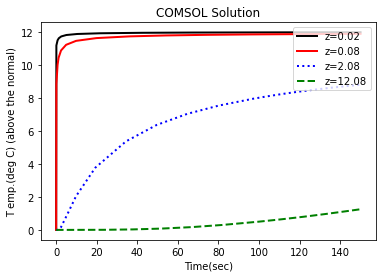

In [71]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
data1= pd.read_csv('Contours.csv')
data2= pd.read_csv('0.08.csv')
data3= pd.read_csv('2.08.csv')
data4= pd.read_csv('0.02.csv')
T1 = np.array(data1.iloc[:,1:2]).T[0]-310.15
t1 = (np.array([np.linspace(0,150,1501)]))[0]
T2 = np.array(data2.iloc[:,1:2]).T[0]-310.15
t2 = (np.array([np.linspace(0,150,1501)]))[0]
T3 = np.array(data3.iloc[:,1:2]).T[0]-310.15
t3 = (np.array([np.linspace(0,150,1501)]))[0]
T4 = np.array(data4.iloc[:,1:2]).T[0]-310.15
t4 = (np.array([np.linspace(0,150,1501)]))[0]

plt.xlabel('Time(sec)')
plt.ylabel('T emp.(deg C) (above the normal)')

plt.plot(t4,T4, color='black', linewidth=2)
plt.plot(t2,T2,color='r', linewidth=2)
plt.plot(t3,T3,color='b', linestyle='dotted', linewidth=2)

plt.plot(t1,T1, color='g', linestyle='dashed', linewidth=2)
plt.title('COMSOL Solution')

plt.legend(['z=0.02', 'z=0.08', 'z=2.08','z=12.08'], loc='upper right')

# Below plot is for showing the variation of temperature with depth after 150 sec

Text(0.5, 1.0, 'Temp vs Depth after 150 seconds')

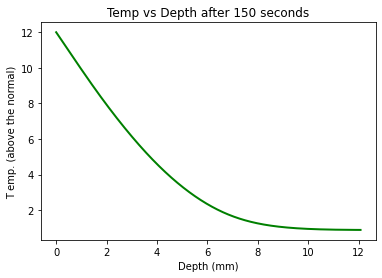

In [38]:
n = 1500
l = 1500
x_star = torch.tensor(np.array([np.linspace(0,10,n)]).T, dtype=dtype, requires_grad=True, device=device)
z_star = torch.tensor(np.array([np.linspace(0,12.08,n)]).T, dtype=dtype, requires_grad=True, device=device)
t_star = torch.tensor(np.array([np.linspace(0,sim_time,n)]).T, dtype=dtype, requires_grad=True, device=device)

T = PINNModel.u_nn(t_star*0+90, x_star,z_star).detach().cpu().numpy().T[0][0:l]
plt.xlabel('Depth (mm)')
plt.ylabel('T emp. (above the normal)')
plt.plot(z,T,color='g', linewidth=2)
plt.title('Temp vs Depth after 150 seconds')

Text(0.5, 1.0, 'Temp vs Depth after 150 seconds')

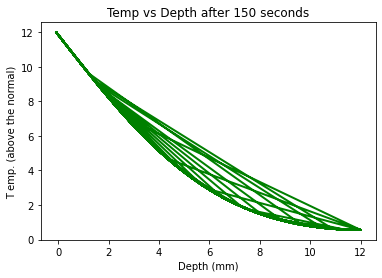

In [91]:
mm = 10000
datan= pd.read_csv('temperature.csv')
T1 = np.array(datan.iloc[:,2:3]).T[0]-310.15
x1 = 12*0.001-np.array(datan.iloc[:,1:2]).T[0]
plt.xlabel('Depth (mm)')
plt.ylabel('T emp. (above the normal)')
plt.plot((x1*1000)[0:mm],T1[0:mm],color='g', linewidth=2)
plt.title('Temp vs Depth after 150 seconds')

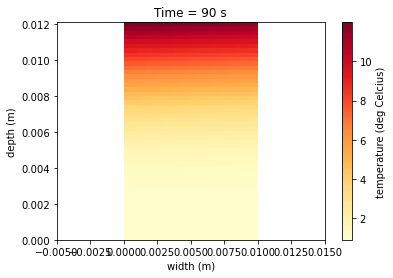

In [40]:
plt.figure()
plt.imshow(T.reshape(50,30),cmap='YlOrRd',extent=[min(x)*0.001,max(x)*0.001,min(z)*0.001,max(z)*0.001],aspect='auto')
plt.xlim(-0.005,0.015)
plt.xlabel('width (m)')
plt.ylabel('depth (m)')
plt.title('Time = 90 s')
plt.colorbar(label='temperature (deg Celcius)')
plt.show()

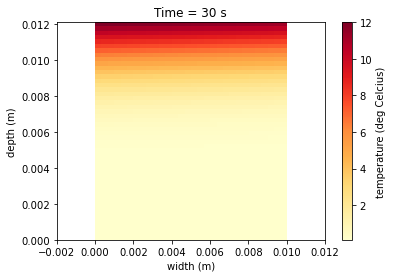

In [37]:
plt.figure()
plt.imshow(T.reshape(50,30),cmap='YlOrRd',extent=[min(x)*0.001,max(x)*0.001,min(z)*0.001,max(z)*0.001],aspect='auto')
plt.xlim(-0.002,0.012)
plt.xlabel('width (m)')
plt.ylabel('depth (m)')
plt.title('Time = 30 s')
plt.colorbar(label='temperature (deg Celcius)')
plt.show()

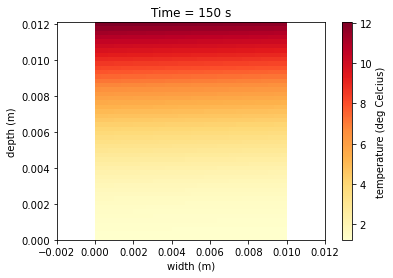

In [26]:
plt.figure()
plt.imshow(T.reshape(50,30),cmap='YlOrRd',extent=[min(x)*0.001,max(x)*0.001,min(z)*0.001,max(z)*0.001],aspect='auto')
plt.xlim(-0.002,0.012)
plt.xlabel('width (m)')
plt.ylabel('depth (m)')
plt.title('Time = 150 s')
plt.colorbar(label='temperature (deg Celcius)')
plt.show()

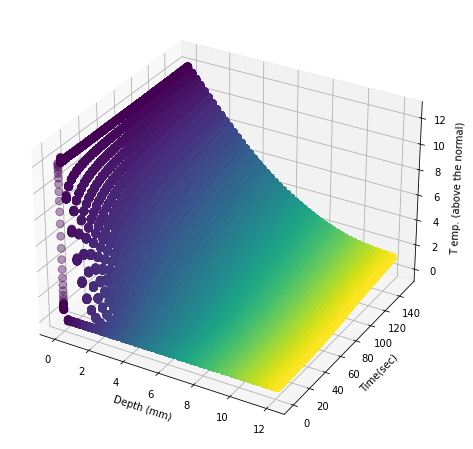

In [9]:
n = 50
l = 50
x_ = (np.array([np.linspace(0,10,n)]).T)
z_ = (np.array([np.linspace(0,12.08,n)]).T)
t_ = (np.array([np.linspace(0,150,n)]).T)
T_,X,Z = np.meshgrid(t_,x_,z_)
X_star = np.hstack((T_.flatten()[:, None], X.flatten()[:, None],Z.flatten()[:, None]))

x_star = torch.tensor(X_star[:,1:2], dtype=dtype, requires_grad=True, device=device)
z_star = torch.tensor(X_star[:,2:3], dtype=dtype, requires_grad=True, device=device)
t_star = torch.tensor(X_star[:,0:1], dtype=dtype, requires_grad=True, device=device)


Tt = PINNModel.u_nn(t_star, x_star,z_star).detach().cpu().numpy()
x = x_star.detach().cpu().numpy().T[0]
z = z_star.detach().cpu().numpy().T[0]
t = t_star.detach().cpu().numpy().T[0]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z, t, Tt,
           linewidths=1, alpha=.4,   
           s = 60,
           c=z)
ax.set_xlabel('Depth (mm)')
ax.set_zlabel('T emp. (above the normal)')
ax.set_ylabel('Time(sec)')
plt.show()